# Novel Inertia Based Human Pose Estimation Using CNN

In [8]:
#setup
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io as sio
from utils import *

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


In [9]:
#Import data from MatLab SimScape Multibody Simulator

#data comes from two files
#1) n trajectories in xyz space, each length m
# traj = np.loadtxt(open("simulation/data/traj1M.txt", "rb"), delimiter=",")
# traj = np.loadtxt(open("simulation/data/traj_random100k.txt", "rb"), delimiter=",")
traj = np.loadtxt(open("simulation/data/traj_with_angs_10k.txt", "rb"), delimiter=",")


trajPts = np.shape(traj)[0] #points per trajectory
# numTraj = np.shape(traj)[1]//3 #number of total trajectories
numTraj = np.shape(traj)[1]//6 #number of total trajectories


#traj needs to be reshaped to a 3d numpy array
#as is traj[n] shows [x,y,z,x,y,z...]


#2) 7 joint angles at the end of the sequence
jointPos = np.loadtxt(open("simulation/data/jointPos_with_angs_10k.txt", "rb"), delimiter=",")
# jointPos = np.loadtxt(open("simulation/data/jointPos_random100k.txt", "rb"), delimiter=",")

# print(traj[-1])
# print(jointPos[0])



In [10]:
#reshape traj data into 3d numpy array
# t = np.zeros([trajPts,3,numTraj]) #net 1
# for j in range(np.shape(traj)[0]):
#     for i in range(np.shape(traj)[1]//3):
#         t[j,:,i] = traj[j,3*i:3*(i+1)]
        
t = np.zeros([trajPts,6,numTraj]) #net 3
for j in range(np.shape(traj)[0]):
    for i in range(np.shape(traj)[1]//6):
        t[j,:,i] = traj[j,6*i:6*(i+1)]

        
# print(t[:,:,0]) #same as in MatLab
print(np.shape(t))
#swap axis so batch size is first axis (for TF)
t = np.swapaxes(t,0,2)
print(np.shape(t)) #[numTraj, xyz, trajPts]
#swap axis again so that conv1D moves on time and not xyz
t = np.swapaxes(t,1,2)
print(np.shape(t))

(10, 6, 10000)
(10000, 6, 10)
(10000, 10, 6)


In [11]:
# from network import Net1 #optim for 1M linear dataset (not ideal because used inconsistant timesteps in solver)
# from network import Net2 #optim for 100k time varying
from network import Net3 #optim for data with position and rotation

np.random.seed(1337)

#convert data from numpy to tensors
x_train = tf.convert_to_tensor(t,np.float32)
y_train = tf.convert_to_tensor(jointPos,np.float32)

# print(tf.shape(x_train))
# print(x_train[0,:,1])

In [14]:
# model = Net1()
model = Net3()

runLen = 100    

def scheduler(epoch, lr):
    part1 = 2*runLen//3
    part2 = 5*runLen//6 #net1

#     part1 = runLen//3
#     part2 = 2*runLen//3 #net2

    if epoch < part1:
        lr = 0.01
        return lr
    if epoch >= part1 and epoch < part2:
        lr = 0.001
        return lr
    if epoch >= part2:
        lr = 0.0001
        return lr

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanSquaredError()],)

summary = model.summary()
print(summary)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

#for 1M linear dataset
# trace = model.fit(x=x_train, y=y_train, batch_size=128, epochs=runLen, verbose=1, 
#                   validation_split=0.1, callbacks = [callback], shuffle=True) 
#New Changes- added 512 conv layer to network #Increases performance drastically (reaches val error of 89.0 in <30 epoch) 
#             adding another layer of 1024 (reaches val error of ~81.5 in <30 epoch)

trace = model.fit(x=x_train, y=y_train, batch_size=32, epochs=runLen, verbose=1, 
                  validation_split=0.1, callbacks = [callback], shuffle=True)



Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10, 6)]      0                                            
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 10, 6)        24          input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 8, 16)        304         batch_normalization_42[0][0]     
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 8, 16)        784         conv1d_33[0][0]                  
_______________________________________________________________________________________

282/282 [==============================] - 2s 9ms/step - loss: 665.9810 - mean_squared_error: 665.9810 - val_loss: 499.4478 - val_mean_squared_error: 499.4478
Epoch 2/100
282/282 [==============================] - 2s 8ms/step - loss: 442.4386 - mean_squared_error: 442.4386 - val_loss: 405.3983 - val_mean_squared_error: 405.3983
Epoch 3/100
282/282 [==============================] - 2s 8ms/step - loss: 415.3629 - mean_squared_error: 415.3629 - val_loss: 420.6691 - val_mean_squared_error: 420.6691
Epoch 4/100
282/282 [==============================] - 2s 8ms/step - loss: 402.3947 - mean_squared_error: 402.3947 - val_loss: 407.2169 - val_mean_squared_error: 407.2169
Epoch 5/100
282/282 [==============================] - 2s 8ms/step - loss: 379.4077 - mean_squared_error: 379.4077 - val_loss: 353.9772 - val_mean_squared_error: 353.9772
Epoch 6/100
282/282 [==============================] - 2s 8ms/step - loss: 377.0948 - mean_squared_error: 377.0948 - val_loss: 358.6138 - val_mean_squared_er

Epoch 49/100
282/282 [==============================] - 2s 8ms/step - loss: 299.2141 - mean_squared_error: 299.2141 - val_loss: 299.3604 - val_mean_squared_error: 299.3604
Epoch 50/100
282/282 [==============================] - 2s 8ms/step - loss: 299.9188 - mean_squared_error: 299.9188 - val_loss: 283.5486 - val_mean_squared_error: 283.5486
Epoch 51/100
282/282 [==============================] - 2s 8ms/step - loss: 298.9355 - mean_squared_error: 298.9355 - val_loss: 297.7919 - val_mean_squared_error: 297.7919
Epoch 52/100
282/282 [==============================] - 2s 8ms/step - loss: 300.7979 - mean_squared_error: 300.7979 - val_loss: 337.5101 - val_mean_squared_error: 337.5101
Epoch 53/100
282/282 [==============================] - 2s 8ms/step - loss: 298.3954 - mean_squared_error: 298.3954 - val_loss: 273.3911 - val_mean_squared_error: 273.3911
Epoch 54/100
282/282 [==============================] - 2s 8ms/step - loss: 292.5292 - mean_squared_error: 292.5292 - val_loss: 276.8167 - v

282/282 [==============================] - 2s 8ms/step - loss: 226.9651 - mean_squared_error: 226.9651 - val_loss: 221.9445 - val_mean_squared_error: 221.9445
Epoch 97/100
282/282 [==============================] - 2s 8ms/step - loss: 228.0954 - mean_squared_error: 228.0954 - val_loss: 222.0982 - val_mean_squared_error: 222.0982
Epoch 98/100
282/282 [==============================] - 2s 8ms/step - loss: 227.0300 - mean_squared_error: 227.0300 - val_loss: 221.7837 - val_mean_squared_error: 221.7837
Epoch 99/100
282/282 [==============================] - 2s 8ms/step - loss: 226.9053 - mean_squared_error: 226.9053 - val_loss: 221.7094 - val_mean_squared_error: 221.7094
Epoch 100/100
282/282 [==============================] - 2s 8ms/step - loss: 227.4608 - mean_squared_error: 227.4608 - val_loss: 222.3421 - val_mean_squared_error: 222.3421


(10.0, 1000.0)

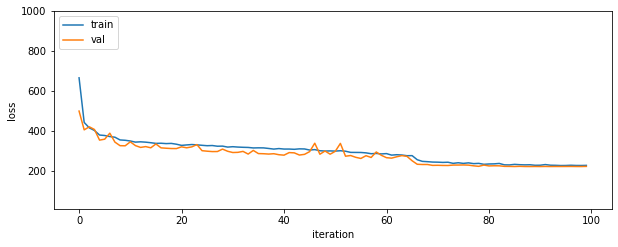

In [15]:
plt.subplot(2, 1, 1)
plt.plot(trace.history['loss'], '-')
plt.plot(trace.history['val_loss'], '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.ylim(10,1000)

In [ ]:
#test model- IMPORTANT TO USE NEVER BEFORE SEEN DATA

#from train data (not ideal to use for testing)
# prediction = model.predict(x_train[-1000:-1])
# actual = y_train[-1000:-1]

#x_data
trajTest = np.loadtxt(open("simulation/data/traj_2sec.txt", "rb"), delimiter=",")
trajPtsTest = np.shape(trajTest)[0] #points per test trajectory
numTrajTest = np.shape(trajTest)[1]//3 #number of test trajectories
tTest = np.zeros([trajPtsTest,3,numTrajTest])
for j in range(np.shape(trajTest)[0]):
    for i in range(np.shape(trajTest)[1]//3):
        tTest[j,:,i] = trajTest[j,3*i:3*(i+1)]
#swap axis so batch size is first axis (for TF)
tTest = np.swapaxes(tTest,0,2)
#swap axis again so that conv1D moves on time and not xyz
tTest = np.swapaxes(tTest,1,2)
x_test = tf.convert_to_tensor(tTest,np.float32)

#y_data
jointPosTest = np.loadtxt(open("simulation/data/jointPos_2sec.txt", "rb"), delimiter=",")
y_test = tf.convert_to_tensor(jointPosTest,np.float32)

prediction = model.predict(x_test)
error = (y_test - prediction)
# print(np.floor(error))

#average error for estimates for each joint
avg = np.average(abs(error),axis=0)
print("average error = ", avg)

#range for each joint:
ranges = [50, 60, 67.5, 110, 120, 360, 130]
rel_error = avg/ranges
print("error as frac of joint range = ", np.floor(rel_error*1000)/1000) #1 is full range of joint
print("total error = ",sum(rel_error))

#current best for network 1 is: 
#                 0.438 @ [0.09  0.082 0.034 0.086 0.061 0.024 0.058]
#                 val_error: 81.84

print(prediction[-10])
print(y_test[-10])

In [ ]:
# model.save("trajectory_cls.kmod")

# model.save("trajectory_random_forces_cls.kmod")


In [ ]:
#load best scoring model for 1M dataset

model = tf.keras.models.load_model("trajectory_cls.kmod")

In [ ]:
#proof my model is doing better than completely random guessing

np.random.seed(None)

# print(actual)
# print(tf.shape(actual)) #[99 7]
B = tf.random.uniform([1000,7])

# B = tf.ones([99,7])
B = B *tf.constant([25., 30., 33.75, 55. , 60., 180., 65.]) + tf.constant([0., 0., 26.25, -35., 30., 0., -65.])

# print(tf.shape(B))
# print(tf.shape(actual))

fake_error = (y_test - B)
# print(fake_error)

fake_avg = tf.math.reduce_mean(tf.math.abs(fake_error), axis=0)
print(fake_avg)

rel_fake_error = fake_avg/ranges

print("error as frac of joint range: ",rel_fake_error)
print("total error: ", sum(rel_fake_error))

#NOTE: these are not all the same becuase the starting ranges for joint positions do NOT fall in the middle of all
#      possible positions for each joint